In [1]:
#Colocamos la ruta del archivo
path='/Users/Leon/Documents/Data GH/Bolsa con ia/Examen 3/01_Datos Iniciales.txt'

In [2]:
#Leemos el archivo
import pandas as pd
df = pd.read_csv(path, sep="\t",header=None)  

#Separamos las variables independientes y dependientes
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values.reshape(-1, 1)

In [3]:
#Reescalamos las variables entre 0 y 1
from sklearn.preprocessing import MinMaxScaler

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y).flatten()

In [4]:
# Separamos los datos en entrenamiento y prueba


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=42)

In [5]:
#Gneramos la funcion de evaluación del polinomio

import numpy as np

def evaluar_polinomio(individuo, X):
    n_variables = X.shape[1]
    n_terminos = len(individuo) // (X.shape[1] + 1)

    y_pred = np.zeros(X.shape[0])

    for i in range(n_terminos):
        coef = individuo[i * (n_variables + 1)]
        exps = individuo[i * (n_variables + 1) + 1 : (i + 1) * (n_variables + 1)]
        y_pred += coef * np.prod(X ** exps, axis=1)
    
    return y_pred


In [6]:
#Calculo del error cuadrático medio

import numpy as np

def generar_individuo(n_variables, n_terminos):
    individuo = []
    for _ in range(n_terminos):
        coef = np.random.uniform(-10, 10)
        exponentes = np.random.randint(0, 4, size=n_variables)  # Exponentes entre 0 y 3
        individuo.extend([coef] + list(exponentes))
    return np.array(individuo)

def generar_poblacion(tamano, n_variables, n_terminos):
    return [generar_individuo(n_variables, n_terminos) for _ in range(tamano)]


In [7]:
from sklearn.metrics import mean_squared_error

def evaluar_fitness(individuo, X, y):
    try:
        y_pred = evaluar_polinomio(individuo, X)

        # Revisar si hay valores inválidos
        if np.any(np.isnan(y_pred)) or np.any(np.isinf(y_pred)):
            return 1e10  # Penalización alta

        return mean_squared_error(y, y_pred)
    
    except Exception:
        # En caso de cualquier error matemático inesperado
        return 1e10

In [8]:
def seleccion(poblacion, puntajes, k=5):
    indices = np.argsort(puntajes)[:k]
    return [poblacion[i] for i in indices]

def cruce(padre1, padre2):
    punto = np.random.randint(1, len(padre1)-1)
    return np.concatenate([padre1[:punto], padre2[punto:]])

def mutacion(individuo, tasa=0.1):
    nuevo = individuo.copy()
    for i in range(len(nuevo)):
        if np.random.rand() < tasa:
            nuevo[i] += np.random.normal(scale=1.0)
    # Limitar coeficientes y exponentes
    nuevo = np.clip(nuevo, -20, 20)

    # Redondear exponentes si corresponde
    for i in range(0, len(nuevo), X.shape[1] + 1):
        nuevo[i+1:i+1+X.shape[1]] = np.clip(np.round(nuevo[i+1:i+1+X.shape[1]]), 0, 5)

    return nuevo



In [9]:
def ascenso_rapido(individuo, X, y, lr=0.01, pasos=10):
    nuevo = individuo.copy()
    for _ in range(pasos):
        grad = np.zeros_like(nuevo)
        f_actual = evaluar_fitness(nuevo, X, y)
        for i in range(len(nuevo)):
            pert = nuevo.copy()
            pert[i] += 1e-5
            grad[i] = (evaluar_fitness(pert, X, y) - f_actual) / 1e-5
        nuevo -= lr * grad
        nuevo = np.clip(nuevo, -20, 20)  # Evitar valores extremos
    return nuevo

def algoritmo_genetico(X, y, generaciones=200, tamano_poblacion=100, n_terminos=10):
    poblacion = generar_poblacion(tamano_poblacion, X.shape[1], n_terminos)

    for gen in range(generaciones):
        puntajes = [evaluar_fitness(ind, X, y) for ind in poblacion]
        elites = seleccion(poblacion, puntajes, k=5)
        nueva_poblacion = elites.copy()

        while len(nueva_poblacion) < tamano_poblacion:
            padres = random.sample(elites, 2)
            hijo = cruce(padres[0], padres[1])
            hijo = mutacion(hijo, tasa=0.05)
            hijo = ascenso_rapido(hijo, X, y)
            nueva_poblacion.append(hijo)

        poblacion = nueva_poblacion

    puntajes_finales = [evaluar_fitness(ind, X, y) for ind in poblacion]
    mejor = poblacion[np.argmin(puntajes_finales)]
    return mejor


In [10]:
import random
def ascenso_rapido(individuo, X, y, lr=0.01, pasos=10):
    nuevo = individuo.copy()
    for _ in range(pasos):
        grad = np.zeros_like(nuevo)
        f_actual = evaluar_fitness(nuevo, X, y)
        for i in range(len(nuevo)):
            pert = nuevo.copy()
            pert[i] += 1e-5
            grad[i] = (evaluar_fitness(pert, X, y) - f_actual) / 1e-5
        nuevo -= lr * grad
    return nuevo

def algoritmo_genetico(X, y, generaciones=50, tamano_poblacion=30, n_terminos=4):
    poblacion = generar_poblacion(tamano_poblacion, X.shape[1], n_terminos)

    for gen in range(generaciones):
        puntajes = [evaluar_fitness(ind, X, y) for ind in poblacion]
        elites = seleccion(poblacion, puntajes, k=5)
        nueva_poblacion = elites.copy()

        while len(nueva_poblacion) < tamano_poblacion:
            
            padres = random.sample(elites, 2)
            hijo = cruce(padres[0], padres[1])
            hijo = mutacion(hijo, tasa=0.05)
            hijo = ascenso_rapido(hijo, X, y)
            nueva_poblacion.append(hijo)

        poblacion = nueva_poblacion

    puntajes_finales = [evaluar_fitness(ind, X, y) for ind in poblacion]
    mejor = poblacion[np.argmin(puntajes_finales)]
    return mejor


In [11]:
mejor_individuo = algoritmo_genetico(X_train, y_train, generaciones=50)

# Mostrar ecuación final
print("Individuo final (coeficientes y exponentes):")
print(mejor_individuo)

# Evaluación en prueba
y_pred = evaluar_polinomio(mejor_individuo, X_test)
error = mean_squared_error(y_test, y_pred)
print("Error cuadrático medio en prueba:", error)


/var/folders/ws/k51gpgfj3j534tm409vzs1q80000gp/T/ipykernel_4501/1003298522.py:14: RuntimeWarning: divide by zero encountered in power
  y_pred += coef * np.prod(X ** exps, axis=1)
/var/folders/ws/k51gpgfj3j534tm409vzs1q80000gp/T/ipykernel_4501/1003298522.py:14: RuntimeWarning: divide by zero encountered in power
  y_pred += coef * np.prod(X ** exps, axis=1)
/var/folders/ws/k51gpgfj3j534tm409vzs1q80000gp/T/ipykernel_4501/1003298522.py:14: RuntimeWarning: divide by zero encountered in power
  y_pred += coef * np.prod(X ** exps, axis=1)
/var/folders/ws/k51gpgfj3j534tm409vzs1q80000gp/T/ipykernel_4501/1003298522.py:14: RuntimeWarning: divide by zero encountered in power
  y_pred += coef * np.prod(X ** exps, axis=1)
/Users/Leon/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/var/folders/ws/k51gpgfj3j534tm409vzs1q80000gp/T/ipykernel_4501/1003298522.py:14: R

Individuo final (coeficientes y exponentes):
[-6.61477147e+00  2.99909759e+00  1.99940436e+00  9.99577908e-01
  1.99865138e+00  1.99980916e+00  1.05574644e+01  2.00108418e+00
  2.00102370e+00  1.05278758e-07  1.00053612e+00  1.99947530e+00
 -9.40776789e+00  2.99903840e+00  1.99931303e+00  2.99951931e+00
  1.99865869e+00  3.99963600e+00  1.64405207e+00  1.00015236e+00
  3.00006004e+00  3.00003967e+00  5.00010358e+00  9.99889403e-01]
Error cuadrático medio en prueba: 0.30784166574500343


/var/folders/ws/k51gpgfj3j534tm409vzs1q80000gp/T/ipykernel_4501/1003298522.py:14: RuntimeWarning: divide by zero encountered in power
  y_pred += coef * np.prod(X ** exps, axis=1)
/Users/Leon/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/var/folders/ws/k51gpgfj3j534tm409vzs1q80000gp/T/ipykernel_4501/1003298522.py:14: RuntimeWarning: divide by zero encountered in power
  y_pred += coef * np.prod(X ** exps, axis=1)
/Users/Leon/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/var/folders/ws/k51gpgfj3j534tm409vzs1q80000gp/T/ipykernel_4501/1003298522.py:14: RuntimeWarning: divide by zero encountered in power
  y_pred += coef * np.prod(X ** exps, axis=1)
/Users/Leon/Library/Python/3.9/lib/python/site-packages/numpy/core

In [12]:
# Si se requiere interpretación con valores originales
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1))


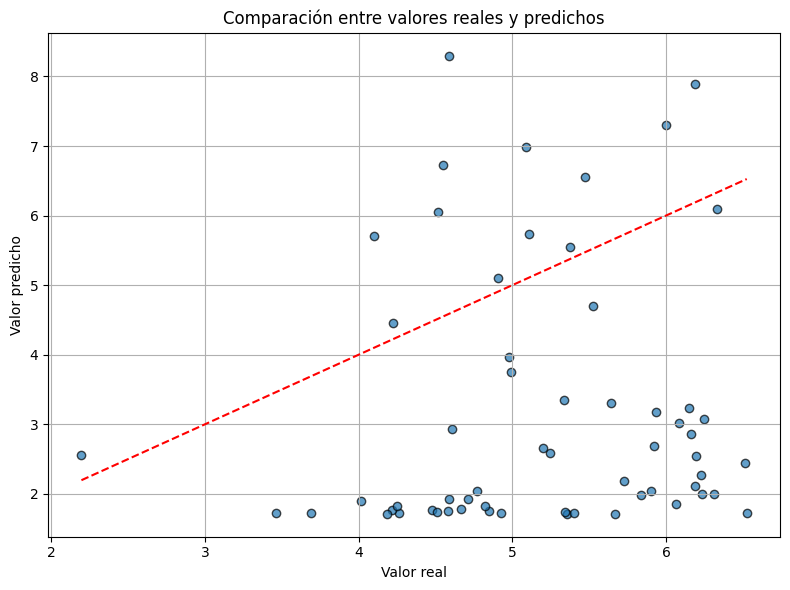

In [13]:
import matplotlib.pyplot as plt

# Si usaste scaler_y para escalar y, deshazlo aquí:
y_test_pred = evaluar_polinomio(mejor_individuo, X_test)
y_test_real = y_test

# Desescalar si es necesario:
if 'scaler_y' in globals():
    y_test_pred = scaler_y.inverse_transform(y_test_pred.reshape(-1, 1)).flatten()
    y_test_real = scaler_y.inverse_transform(y_test_real.reshape(-1, 1)).flatten()

# Gráfica
plt.figure(figsize=(8, 6))
plt.scatter(y_test_real, y_test_pred, alpha=0.7, edgecolors='k')
plt.plot([min(y_test_real), max(y_test_real)], [min(y_test_real), max(y_test_real)], 'r--')
plt.xlabel("Valor real")
plt.ylabel("Valor predicho")
plt.title("Comparación entre valores reales y predichos")
plt.grid(True)
plt.tight_layout()
plt.show()
